In [160]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

In [4]:
data_src = "./football_data.csv"
df = pd.read_csv(data_src, )

In [5]:
df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [104]:
filters = ['Age', 'Overall', 'Potential', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']
# filters = ['Overall', 'Age', 'International Reputation']
df.fillna(method ='ffill', inplace = True)
df_filtered = df[filters]
df_filtered.head()

Age  Overall  Potential  International Reputation  Weak Foot  Skill Moves  \
0   31       94         94                       5.0        4.0          4.0   
1   33       94         94                       5.0        4.0          5.0   
2   26       92         93                       5.0        5.0          5.0   
3   27       91         93                       4.0        3.0          1.0   
4   27       91         92                       4.0        5.0          4.0   

   Crossing  Finishing  HeadingAccuracy  ShortPassing  ...  Penalties  \
0      84.0       95.0             70.0          90.0  ...       75.0   
1      84.0       94.0             89.0          81.0  ...       85.0   
2      79.0       87.0             62.0          84.0  ...       81.0   
3      17.0       13.0             21.0          50.0  ...       40.0   
4      93.0       82.0             55.0          92.0  ...       79.0   

   Composure  Marking  StandingTackle  SlidingTackle  GKDiving  GKHandling  \
0       96.0     33.0            28.0           26.0       6.0        11.0   
1       95.0     28.0            31.0           23.0       7.0        11.0   
2       94.0     27.0            24.0           33.0       9.0         9.0   
3       68.0     15.0            21.0           13.0      90.0        85.0   
4       88.0     68.0            58.0           51.0      15.0        13.0   

   GKKicking  GKPositioning  GKReflexes  
0       15.0           14.0         8.0  
1       15.0           14.0        11.0  
2       15.0           15.0        11.0  
3       87.0           88.0        94.0  
4        5.0           10.0        13.0  

[5 rows x 40 columns]

In [105]:
# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_filtered)

# Normalizing the data so that 
# the data approximately follows a Gaussian distribution
df_normalized = normalize(df_scaled)

# Converting the numpy array into a pandas DataFrame
df_normalized = pd.DataFrame(df_normalized)

In [237]:
pca = PCA(n_components = 2)
df_principal = pca.fit_transform(df_normalized)
df_principal = pd.DataFrame(df_principal)
df_principal.columns = ['P1', 'P2']
df_principal.head()

# df_normalized.columns = ['P1', 'P2']
# df_principal = df_normalized

P1        P2
0 -0.629802  0.155547
1 -0.609955  0.070052
2 -0.607788  0.174131
3  0.423162  0.089612
4 -0.690726 -0.060608

In [107]:
df_principal

P1        P2
0     -0.629802  0.155547
1     -0.609955  0.070052
2     -0.607788  0.174131
3      0.423162  0.089612
4     -0.690726 -0.060608
...         ...       ...
18202  0.736363  0.273336
18203  0.801476  0.407984
18204  0.624338  0.645783
18205  0.576826  0.598098
18206  0.789574  0.186374

[18207 rows x 2 columns]

In [108]:
def cluster_quality(clusters):
    clusters_centers = clusters.groupby(['Cluster_id']).mean().reset_index()
    cluster_sums = []
    for i,r in clusters_centers.iterrows():
        neighbors = clusters[clusters['Cluster_id'] == r['Cluster_id']]
        dist = (neighbors['P1'] - r['P1'])**2 + (neighbors['P2'] - r['P2'])**2
        cluster_sums.append(np.sum(dist))
    quality = np.sum(np.array(cluster_sums))
    return quality

In [116]:
def tune_dbscan(src_df, eps, minsamples):
    global exp_scores
    db_default = DBSCAN(eps = eps, min_samples = minsamples).fit(src_df)
    labels = db_default.labels_
    src_df['Cluster_id'] = labels

    exp_scores['epsilon'].append(round(eps,2))
    exp_scores['minpts'].append(minsamples)
    exp_scores['clusters'].append(len(set(labels)))
    exp_scores['quality'].append(cluster_quality(src_df))
    
    # print("Epsilon: ", "%.2f" % eps, "MinPts: ", minsamples, "Clusters: ", len(set(labels)), "Quality: ", cluster_quality(src_df))
    # sns.scatterplot(data=src_df, x='P1', y='P2', hue='Cluster_id')

In [114]:
exp_scores = {
    "epsilon": [], 
    "minpts": [], 
    "clusters": [], 
    "quality": [] 
}

In [117]:
eps = 0.0300
for e in tqdm(np.arange(0.01, 1.3, 0.01)):
    for i in range(36,200,10):
        tune_dbscan(df_principal.copy(deep=True), e, i)

100%|██████████| 129/129 [56:25<00:00, 26.24s/it]



To find the optimal values for $\epsilon$ and MinPts, we ran DBScan for all the values of $\epsilon$ ranging from 0.01 to 1.3 in steps of 0.01, AND all the values of MinPts ranging from 36 to 200 (steps of 10).

In [126]:
exp_df = pd.DataFrame(exp_scores)
exp_srtby_quality = exp_df.sort_values(by=['quality'])
exp_grpby_eps = exp_df.groupby(['epsilon']).mean().reset_index()
exp_grpby_minpts = exp_df.groupby(['minpts']).mean().reset_index()

Now we try to find the average trend for both $\epsilon$ and MinPt.

<AxesSubplot:xlabel='epsilon', ylabel='quality'>

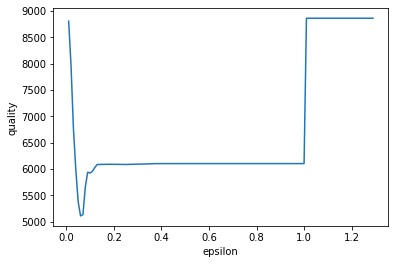

In [128]:
exp_grpby_eps
sns.lineplot(data=exp_grpby_eps, x='epsilon',y='quality')

Here we can see that there is a sharp dip for $\epsilon$ around the value $0.05$.

<AxesSubplot:xlabel='minpts', ylabel='quality'>

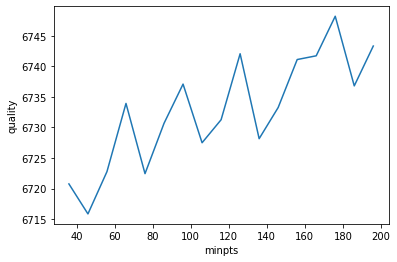

In [131]:
exp_grpby_minpts
sns.lineplot(data=exp_grpby_minpts, x='minpts', y='quality')

Here we don't see a unique trend or observe any patterns. MinPts does not seem to be a decisive factor as it only account for 5% of the change in quality. Thus, we will now attempt to find a trend with respect to MinPts with $\epsilon$ fixed at $0.05$.

<AxesSubplot:xlabel='minpts', ylabel='quality'>

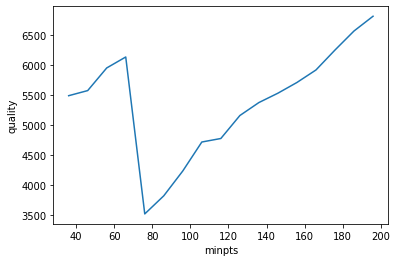

In [137]:
exp_05 = exp_df[exp_df['epsilon']==0.05]
sns.lineplot(data=exp_05, x='minpts', y='quality')

Here we notice that the optimal cluster quality is achieved for MinPts $\approx 75$. Now we can use this found pattern and infer by sorting the experiment results by quality.

In [138]:
exp_srtby_quality

epsilon  minpts  clusters      quality
72       0.05      76        11  3513.515088
113      0.07     146         5  3562.911766
134      0.08     186         5  3605.345485
135      0.08     196         4  3718.930789
112      0.07     136         5  3720.705691
...       ...     ...       ...          ...
1846     1.09     136         1  8861.719618
1845     1.09     126         1  8861.719618
1844     1.09     116         1  8861.719618
1857     1.10      76         1  8861.719618
2192     1.29     196         1  8861.719618

[2193 rows x 4 columns]

This shows us that the optimal quality was obtained at $\epsilon=0.05$ and MinPts $=76$, which is in-line with out previous observation of trends. Therefore, we will plot the scatterplots for the optimal values.

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
-0.0687560601847092


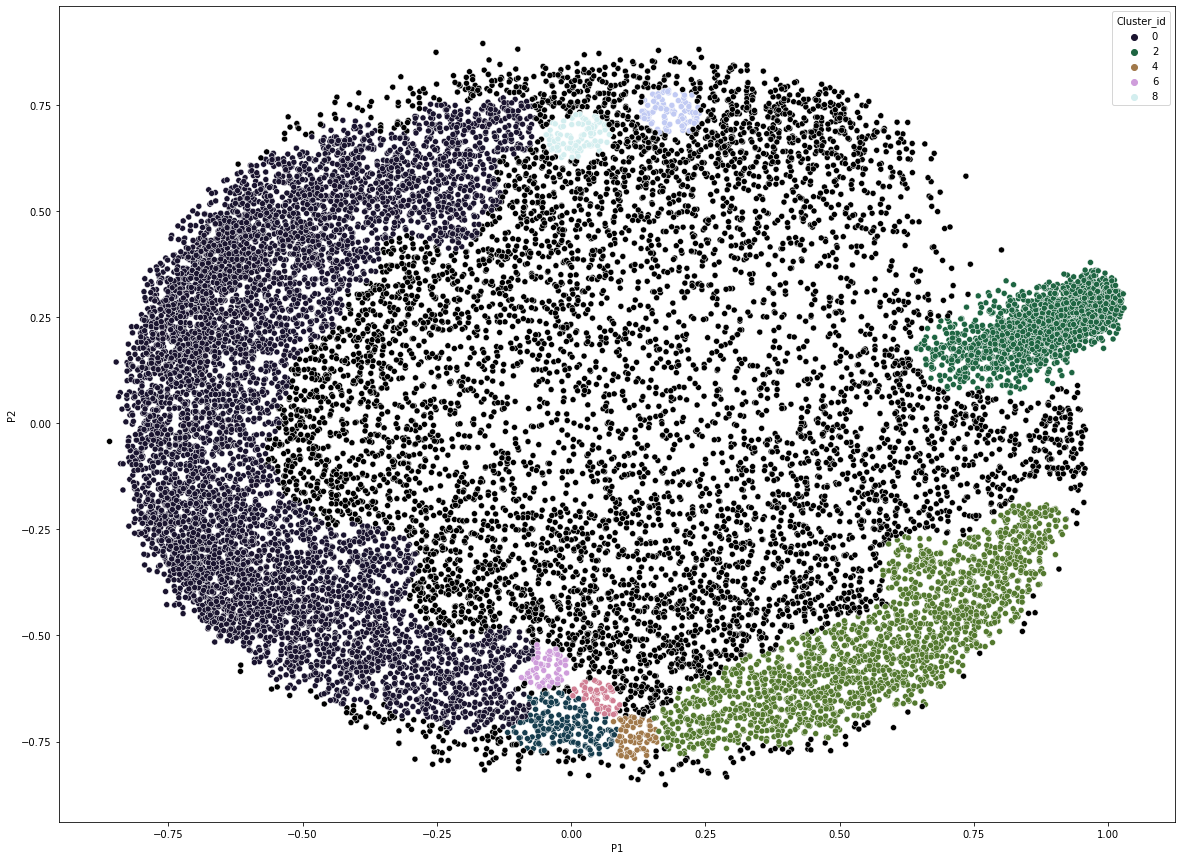

3513.515087932026


In [181]:
db_default = DBSCAN(eps = 0.050, min_samples = 76).fit(df_principal.copy(deep=True))
labels = db_default.labels_
print(set(labels))
print(silhouette_score(df_principal, labels))
df_principal['Cluster_id'] = labels
fig = plt.figure(figsize=(20,15))
sns.scatterplot(data=df_principal, x='P1', y='P2', hue='Cluster_id', palette="cubehelix")
plt.show()
print(cluster_quality(df_principal))

{0, 1, 2, 3, -1}
0.16330805460213285


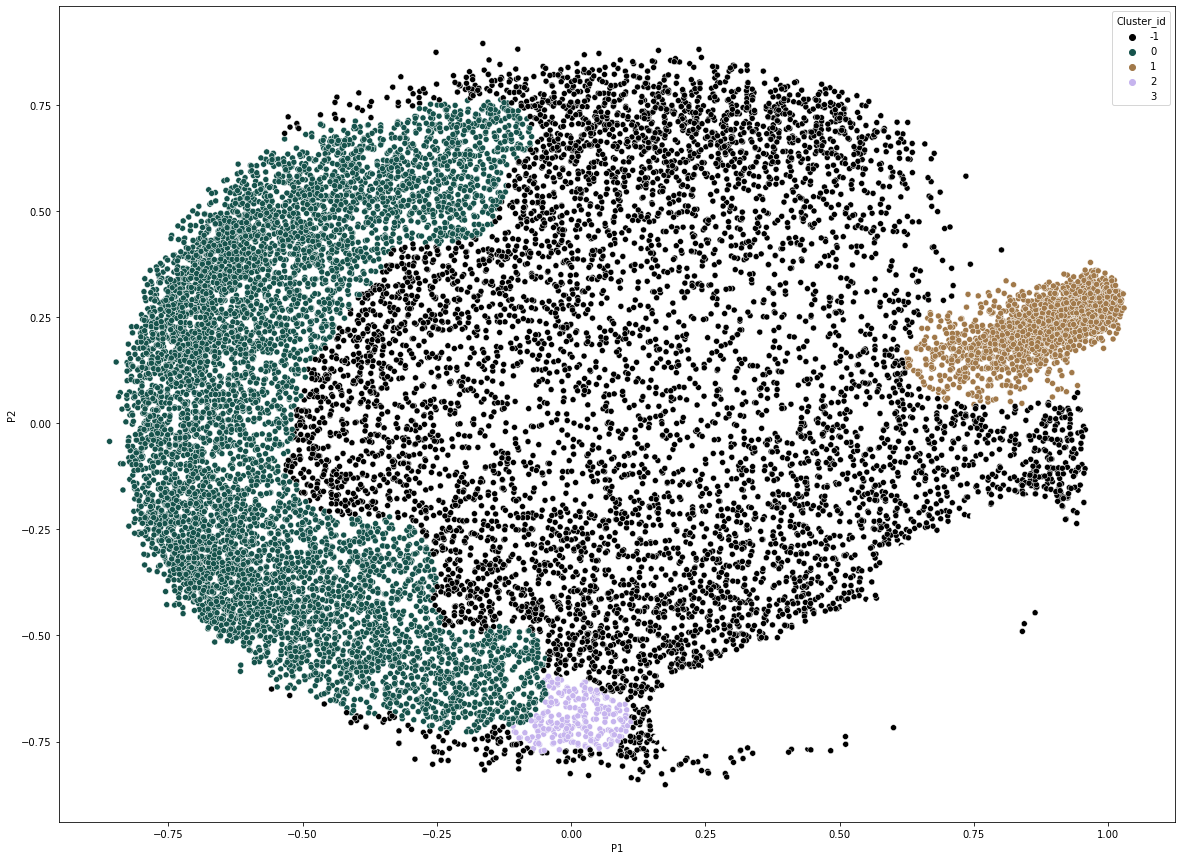

3562.9117666018146


In [184]:
db_default = DBSCAN(eps = 0.07, min_samples = 146).fit(df_principal.copy(deep=True))
labels = db_default.labels_
print(set(labels))
print(silhouette_score(df_principal, labels))
df_principal['Cluster_id'] = labels
fig = plt.figure(figsize=(20,15))
sns.scatterplot(data=df_principal, x='P1', y='P2', hue='Cluster_id', palette="cubehelix")
plt.show()
print(cluster_quality(df_principal))


In these plots, the points labelled by '$-1$' are outliers and are not clustered.

From the above plots of two experiments of best qualities, the clustering with $\epsilon=0.07$ is not ideal because most of the data is noise data.
For the plot with $\epsilon=0.05$, we observe formation of 11 clusters with no noise data and it has the minimum sum of squared errors (SSE) (and hence highest quality).

In [90]:
cluster_quality(df_principal)

35.48624293851674

In [193]:
def newtune_dbscan(src_df, eps, minsamples):
    global new_exp_scores
    db_default = DBSCAN(eps = eps, min_samples = minsamples).fit(src_df)
    labels = db_default.labels_
    src_df['Cluster_id'] = labels
    print("ep:", eps, "minpts: ", minsamples, "labels: ", set(labels))

    new_exp_scores['epsilon'].append(round(eps,2))
    new_exp_scores['minpts'].append(minsamples)
    new_exp_scores['clusters'].append(len(set(labels)))
    new_exp_scores['quality'].append(cluster_quality(src_df))
    new_exp_scores['sscore'].append(silhouette_score(src_df,labels))


In [224]:
new_exp_scores = {
    "epsilon": [], 
    "minpts": [], 
    "clusters": [], 
    "sscore":[],
    "quality": [] 
}
eps = 0.0300
for e in tqdm(np.arange(0.04, 0.07, 0.01)):
    for i in range(36,200,20):
        newtune_dbscan(df_principal.copy(deep=False), e, i)

  0%|          | 0/4 [00:00<?, ?it/s]

ep: 0.04 minpts:  36 labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1}
ep: 0.04 minpts:  56 labels:  {0, 1, 2, 3, 4, 5, 6, 7, -1}
ep: 0.04 minpts:  76 labels:  {0, 1, 2, 3, 4, 5, -1}
ep: 0.04 minpts:  96 labels:  {0, 1, 2, 3, -1}
ep: 0.04 minpts:  116 labels:  {0, 1, 2, 3, 4, 5, -1}
ep: 0.04 minpts:  136 labels:  {0, 1, -1}
ep: 0.04 minpts:  156 labels:  {0, -1}
ep: 0.04 minpts:  176 labels:  {0, -1}
ep: 0.04 minpts:  196 labels:  {0, -1}


 25%|██▌       | 1/4 [00:57<02:53, 57.91s/it]

ep: 0.05 minpts:  36 labels:  {0, 1, 2, 3, 4, 5, 6, -1}
ep: 0.05 minpts:  56 labels:  {0, 1, 2, -1}
ep: 0.05 minpts:  76 labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
ep: 0.05 minpts:  96 labels:  {0, 1, 2, 3, 4, 5, 6, 7, -1}
ep: 0.05 minpts:  116 labels:  {0, 1, 2, 3, 4, -1}
ep: 0.05 minpts:  136 labels:  {0, 1, 2, -1}
ep: 0.05 minpts:  156 labels:  {0, 1, 2, 3, -1}
ep: 0.05 minpts:  176 labels:  {0, 1, 2, 3, -1}
ep: 0.05 minpts:  196 labels:  {0, 1, -1}


 50%|█████     | 2/4 [01:59<01:59, 59.84s/it]

ep: 0.060000000000000005 minpts:  36 labels:  {0, -1}
ep: 0.060000000000000005 minpts:  56 labels:  {0, 1, 2, 3, -1}
ep: 0.060000000000000005 minpts:  76 labels:  {0, 1, -1}
ep: 0.060000000000000005 minpts:  96 labels:  {0, 1, -1}
ep: 0.060000000000000005 minpts:  116 labels:  {0, 1, 2, -1}
ep: 0.060000000000000005 minpts:  136 labels:  {0, 1, 2, 3, -1}
ep: 0.060000000000000005 minpts:  156 labels:  {0, 1, 2, -1}
ep: 0.060000000000000005 minpts:  176 labels:  {0, 1, 2, -1}
ep: 0.060000000000000005 minpts:  196 labels:  {0, 1, 2, -1}


 75%|███████▌  | 3/4 [03:02<01:01, 61.30s/it]

ep: 0.07 minpts:  36 labels:  {0, -1}
ep: 0.07 minpts:  56 labels:  {0, -1}
ep: 0.07 minpts:  76 labels:  {0, 1, -1}
ep: 0.07 minpts:  96 labels:  {0, 1, -1}
ep: 0.07 minpts:  116 labels:  {0, 1, 2, -1}
ep: 0.07 minpts:  136 labels:  {0, 1, 2, 3, -1}
ep: 0.07 minpts:  156 labels:  {0, 1, 2, -1}
ep: 0.07 minpts:  176 labels:  {0, 1, 2, -1}
ep: 0.07 minpts:  196 labels:  {0, 1, 2, -1}


100%|██████████| 4/4 [04:00<00:00, 60.25s/it]


In [225]:
expss_df = pd.DataFrame(new_exp_scores)
expss_srtby_sscore = expss_df.sort_values(by=['sscore'])
expss_grpby_eps = expss_df.groupby(['epsilon']).mean().reset_index()
expss_grpby_minpts = expss_df.groupby(['minpts']).mean().reset_index()

<AxesSubplot:xlabel='epsilon', ylabel='sscore'>

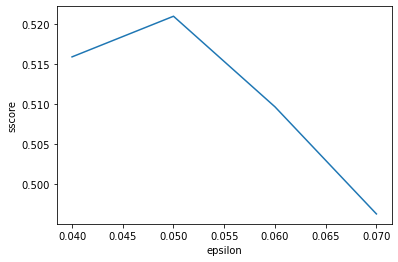

In [226]:
expss_grpby_eps
sns.lineplot(data=expss_grpby_eps, x='epsilon',y='sscore')

<AxesSubplot:xlabel='minpts', ylabel='sscore'>

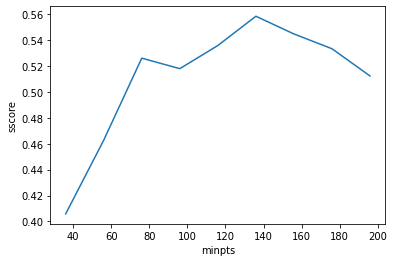

In [227]:
expss_grpby_minpts
sns.lineplot(data=expss_grpby_minpts, x='minpts', y='sscore')

<AxesSubplot:xlabel='minpts', ylabel='sscore'>

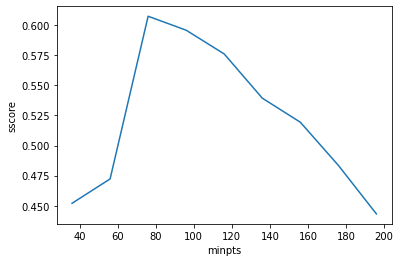

In [228]:
expss_05 = expss_df[expss_df['epsilon']==0.05]
sns.lineplot(data=expss_05, x='minpts', y='sscore')

In [229]:
expss_srtby_sscore

epsilon  minpts  clusters    sscore      quality
28     0.07      56         2  0.314420  8800.421015
18     0.06      36         2  0.320195  8809.482249
27     0.07      36         2  0.363623  8853.969897
17     0.05     196         3  0.443228  6807.260265
9      0.05      36         8  0.452052  6422.856380
19     0.06      56         5  0.454704  6368.802043
29     0.07      76         3  0.456071  6394.634290
30     0.07      96         3  0.465919  6317.426814
20     0.06      76         3  0.471753  6277.578547
10     0.05      56         4  0.472275  6263.320311
31     0.07     116         4  0.479590  6117.070990
4      0.04     116         7  0.482546  6224.289356
16     0.05     176         5  0.483549  6244.194349
21     0.06      96         3  0.485608  6142.996025
0      0.04      36        12  0.487431  6103.056113
8      0.04     196         2  0.488926  7111.845876
7      0.04     176         2  0.490724  7075.713893
6      0.04     156         2  0.492734  7036.347529
5      0.04     136         3  0.498761  6918.228576
15     0.05     156         5  0.519373  5703.703449
3      0.04      96         5  0.524177  5623.283978
14     0.05     136         4  0.539387  5369.155242
26     0.06     196         4  0.544194  5294.762276
24     0.06     156         4  0.558312  4926.584367
25     0.06     176         4  0.561750  4991.654409
2      0.04      76         7  0.568657  4862.882291
35     0.07     196         4  0.572461  4673.003290
13     0.05     116         6  0.576048  4770.282397
23     0.06     136         5  0.585797  4331.740859
12     0.05      96         9  0.595775  4229.733979
34     0.07     176         4  0.596875  4123.891979
22     0.06     116         4  0.604672  3858.810292
11     0.05      76        11  0.607377  3513.515087
33     0.07     156         4  0.608088  3808.333893
32     0.07     136         5  0.609219  3720.705690
1      0.04      56         9  0.609314  3869.415596

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}


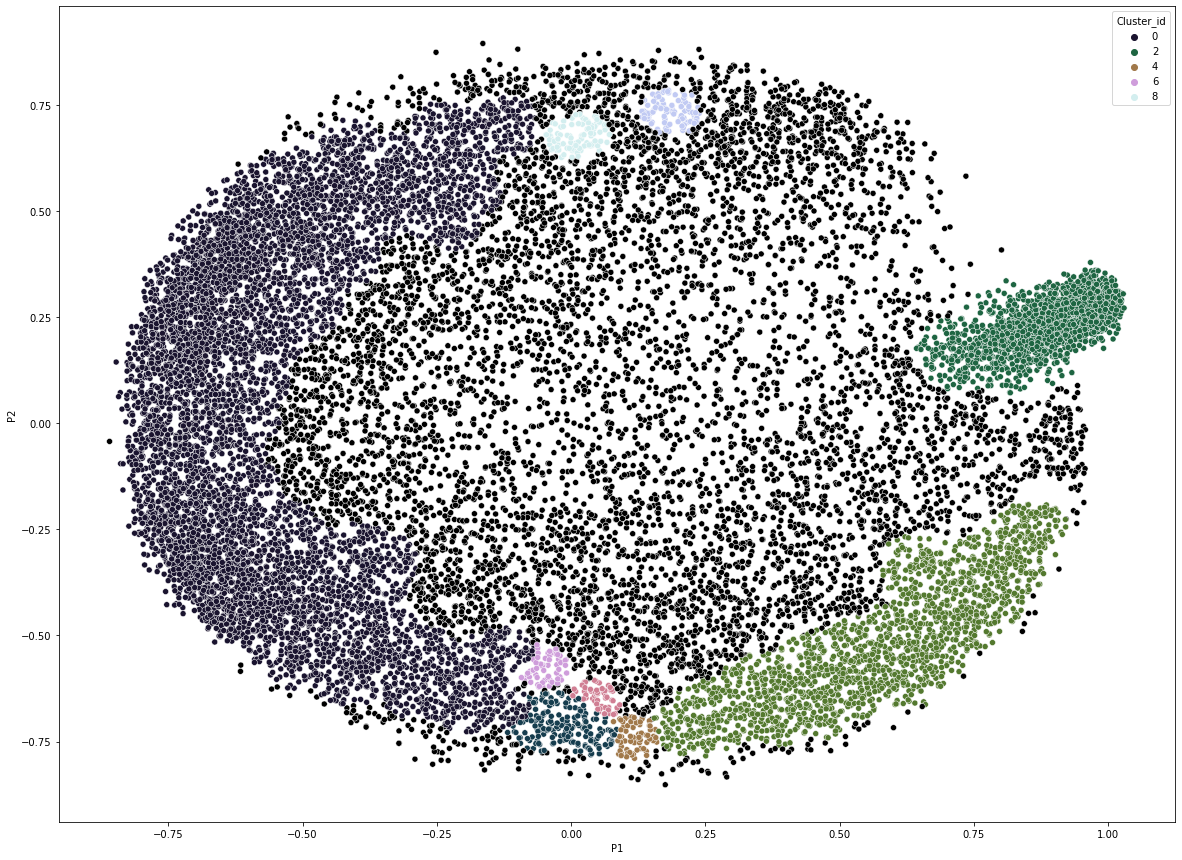

In [244]:
df_passing = df_principal.copy(deep=False)
db_default = DBSCAN(eps = 0.05, min_samples = 76).fit(df_passing)
labels = db_default.labels_
print(set(labels))
# print(silhouette_score(df_passing, labels))
df_passing['Cluster_id'] = labels
fig = plt.figure(figsize=(20,15))
sns.scatterplot(data=df_passing, x='P1', y='P2', hue='Cluster_id', palette="cubehelix")
plt.show()
# print(cluster_quality(df_passing))

In [214]:
for e in tqdm(np.arange(0.05, 0.07, 1)):
    for i in range(46,50,10):
        newtune_dbscan(df_principal.copy(deep=False), e, i)

  0%|          | 0/1 [00:00<?, ?it/s]

ep: 0.05 minpts:  46 labels:  {0, 1, 2, -1}


100%|██████████| 1/1 [00:07<00:00,  7.40s/it]
